
# Bank Marketing — Pré-processamento e Clusterização

Este notebook conduz um fluxo completo de pré processamento e clusterização para o dataset **Bank Marketing (UCI)**:
1) **Carregamento e checagens iniciais**  
2) **Limpeza e engenharia de variáveis** (flags de cancelamento/ajuste, valor por linha, etc.)  

> Observações
> - Os métodos de clustering normalmente usam métricas que envolvem distância e minimiza a variância intra-cluster; por isso precisamos **padronizar** as features.  

Link de acesso ao dataset: https://archive.ics.uci.edu/dataset/222/bank+marketing

In [1]:
#Import necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
import os
import sys
import pandas as pd
from time import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import jensenshannon

notebook_dir = os.getcwd()
src_path = os.path.abspath(os.path.join(notebook_dir, '..', 'src'))
sys.path.append(src_path)
from dbscan import DBSCAN
from kmeans import KMeans
from kmedoids import KMedoids
from wardmethod import WardMethod
from expectationmaximization import ExpectationMaximization
import distance_metrics
from evaluationmetrics import EvaluationMetrics
from func_auxiliar import plot_algorithm_all_metrics, calculate_clustering_metrics, generate_synthetic_blobs, plot_algorithm_all_metrics_3d, plot_melhor_k_silhouette_and_sse, to_probability_simplex

In [2]:

FILE_PATH = "/root/jane-oliveira/tcc-git/clustering-client-segmentation-tcc/data/DatasetRaw/bank-marketing/bank.csv"

# Leitura do CSV com separador ;
df = pd.read_csv(FILE_PATH, sep=";")

# Selecionar apenas as colunas esperadas
expected_cols = ['age','job','marital','education','default','balance','housing','loan',
                 'contact','day','month','duration','campaign','pdays','previous','poutcome','y']
df = df[expected_cols]

df.head()


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [3]:
# 1) Remover duplicados (por segurança)
df = df.drop_duplicates()

# 2) Garantir que as colunas numéricas importantes são numéricas mesmo
num_cols = ["balance", "campaign", "pdays", "previous"]

for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# 3) Dropar linhas onde alguma dessas colunas ficou NaN (caso o arquivo venha sujo)
df = df.dropna(subset=num_cols)

In [4]:
# Confirma qual é o valor de "nunca contatado" (geralmente 999 no UCI original, as vezes -1 em versões tratadas)
valor_nunca_contatado = -1 
if 999 in df['pdays'].unique():
    valor_nunca_contatado = 999

valor_nunca_contatado

-1

In [5]:
df_experiment = df.copy()

In [6]:
# flag: já tinha sido contatado em campanhas anteriores?
df_experiment["was_contacted_before"] = (df_experiment["pdays"] != -1).astype(int)

In [7]:
# pega só quem tem pdays "real"
mask_contacted = df_experiment["pdays"] != -1
max_real_pdays = df_experiment.loc[mask_contacted, "pdays"].max()

In [8]:
# Recência de contato:
# - quem nunca foi contatado recebe max_real_pdays + 1 (mais "antigo" que todos)
df_experiment["Recency"] = np.where(
    df_experiment["pdays"] == -1,
    max_real_pdays + 1,
    df_experiment["pdays"]
)

In [9]:
df_experiment["Frequency"] = df_experiment["campaign"] + df_experiment["previous"]

In [10]:
min_balance = df_experiment["balance"].min()
shift = -min_balance + 1 if min_balance <= 0 else 0

df_experiment["balance_shifted"] = df_experiment["balance"] + shift
df_experiment["M_balance"] = np.log1p(df_experiment["balance_shifted"])
df_experiment.drop(columns=["balance_shifted"], inplace=True)

In [11]:
rfm= df_experiment[["Recency", "Frequency", "M_balance"]].copy()
rfm.head()

,Recency,Frequency,M_balance
0,872,1,8.537388
1,339,5,9.000113
2,330,2,8.447843
3,872,4,8.474494
4,872,1,8.106213


In [12]:
scaler = MinMaxScaler()
df_scalar = scaler.fit_transform(rfm)

X = pd.DataFrame(
    df_scalar,
    columns=["R_norm", "F_norm", "M_norm"],
    index=df_experiment.index
)
X.head()

,R_norm,F_norm,M_norm
0,1.000000,0.000000,0.745264
1,0.388060,0.081633,0.789227
2,0.377727,0.020408,0.736757
3,1.000000,0.061224,0.739289
4,1.000000,0.000000,0.704299


In [13]:
rfm_full = (
    rfm
    .join(X)  # adiciona Recency_scaled, Frequency_scaled, Monetary_scaled
    .join(df_experiment["y"].map({"no": 0, "yes": 1}))  # adiciona a coluna alvo 'y'
    .join(df_experiment["age"].astype(int))  # adiciona a coluna de idade
    .join(df_experiment["housing"].map({"no": 0, "yes": 1}))
    .join(df_experiment["marital"])
    .join(df_experiment["education"])
)

rfm_full.head()

,Recency,Frequency,M_balance,R_norm,F_norm,M_norm,y,age,housing,marital,education
0,872,1,8.537388,1.000000,0.000000,0.745264,0,30,0,married,primary
1,339,5,9.000113,0.388060,0.081633,0.789227,0,33,1,married,secondary
2,330,2,8.447843,0.377727,0.020408,0.736757,0,35,1,single,tertiary
3,872,4,8.474494,1.000000,0.061224,0.739289,0,30,1,married,tertiary
4,872,1,8.106213,1.000000,0.000000,0.704299,0,59,1,married,secondary


In [14]:
X_jsd = to_probability_simplex(X)

In [15]:
#Estudo do melhor k para K-Means
results_k = []
from sklearn.metrics import silhouette_score
for k in range(2, 11):
    kmeans = KMeans(k=k, max_iterations=300, metric_name='euclidean_distance')
    centroids_kmeans, clusters_kmeans = kmeans.fit(X)
    diffs = (X - centroids_kmeans[clusters_kmeans]) ** 2
    sse = diffs.sum(axis=0).sum()
    sil = silhouette_score(X, clusters_kmeans)
    results_k.append({"k": k,
        "sse_euclidean": sse,
        "silhouette": sil,
        "algoritmo": "K-Means"
    })
    

Convergiu na iteração 4
Convergiu na iteração 11
Convergiu na iteração 11
Convergiu na iteração 18
Convergiu na iteração 28
Convergiu na iteração 18
Convergiu na iteração 21
Convergiu na iteração 27
Convergiu na iteração 15


In [16]:
df_k_search = pd.DataFrame(results_k)
df_k_search

,k,sse_euclidean,silhouette,algoritmo
0,2,39.649049,0.875366,K-Means
1,3,29.331918,0.728302,K-Means
2,4,19.932781,0.701207,K-Means
3,5,23.367989,0.574141,K-Means
4,6,22.834767,0.505141,K-Means
5,7,22.328251,0.506375,K-Means
6,8,22.059292,0.418569,K-Means
7,9,20.593156,0.482502,K-Means
8,10,10.062839,0.494640,K-Means


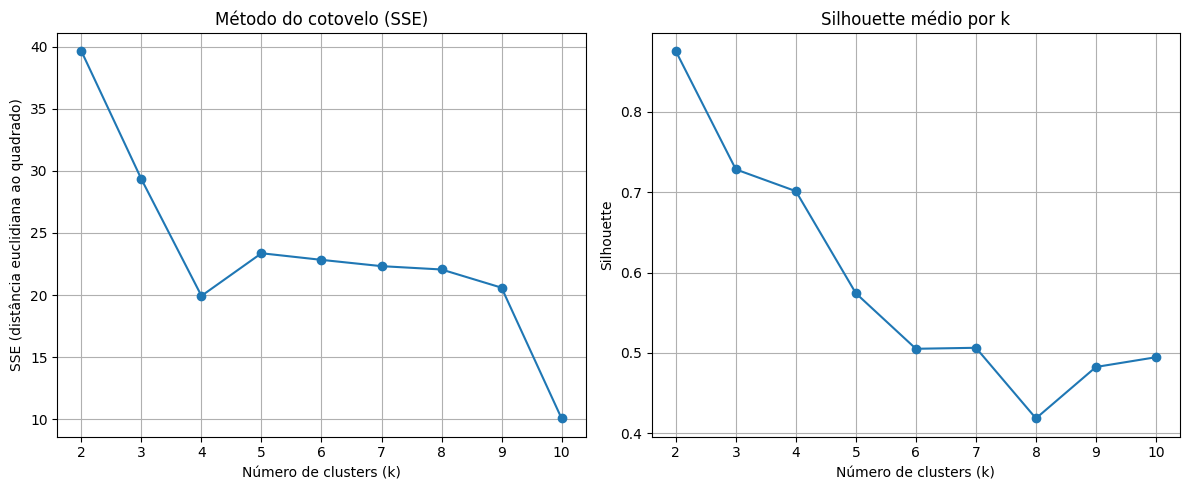

In [17]:
plot_melhor_k_silhouette_and_sse(df_k_search[df_k_search['algoritmo'] == 'K-Means'])

In [20]:
#Estudo do melhor k para K-medoids
from sklearn.metrics import silhouette_score
for k in range(2, 11):
    kmedoids = KMedoids(k=k, max_iterations=300, metric_name='euclidean_distance')
    centroids_kmedoids, clusters_kmedoids = kmedoids.fit(X)
    diffs = (X - centroids_kmedoids[clusters_kmedoids]) ** 2
    sse = diffs.sum(axis=0).sum()
    sil = silhouette_score(X, clusters_kmedoids)
    results_k.append({"k": k,
        "sse_euclidean": sse,
        "silhouette": sil,
        "algoritmo": "K-Medoids"
    })
    print(f"Completed k={k} for K-Medoids")
    

K-Medoids convergiu na iteração 2
Completed k=2 for K-Medoids
K-Medoids convergiu na iteração 14
Completed k=3 for K-Medoids
K-Medoids convergiu na iteração 6
Completed k=4 for K-Medoids
K-Medoids convergiu na iteração 13
Completed k=5 for K-Medoids
K-Medoids convergiu na iteração 15
Completed k=6 for K-Medoids
K-Medoids convergiu na iteração 8
Completed k=7 for K-Medoids
K-Medoids convergiu na iteração 40
Completed k=8 for K-Medoids
K-Medoids convergiu na iteração 9
Completed k=9 for K-Medoids
K-Medoids convergiu na iteração 33
Completed k=10 for K-Medoids


In [21]:
df_k_search = pd.DataFrame(results_k)
df_k_search

,k,sse_euclidean,silhouette,algoritmo
0,2,39.649049,0.875366,K-Means
1,3,29.331918,0.728302,K-Means
2,4,19.932781,0.701207,K-Means
3,5,23.367989,0.574141,K-Means
4,6,22.834767,0.505141,K-Means
5,7,22.328251,0.506375,K-Means
6,8,22.059292,0.418569,K-Means
7,9,20.593156,0.482502,K-Means
8,10,10.062839,0.494640,K-Means
9,2,41.520013,0.875366,K-Medoids


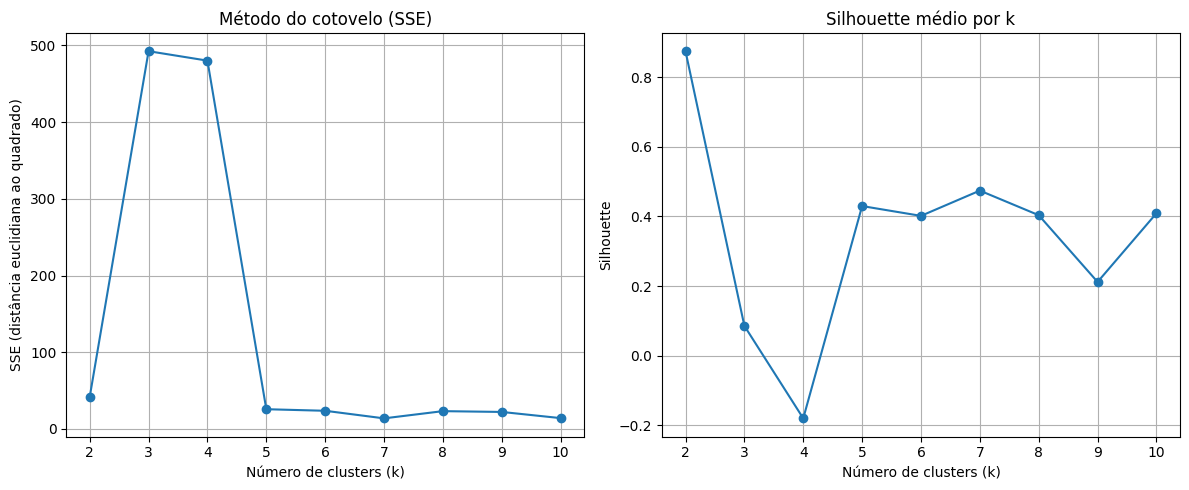

In [22]:
plot_melhor_k_silhouette_and_sse(df_k_search[df_k_search['algoritmo'] == 'K-Medoids'])

### Algoritmo: Kmeans

In [ ]:
metrics = ['euclidean_distance', 'manhattan_distance', 'cosine_distance', 'mahalanobis_distance', 'jensen-shannon_distance']



In [24]:
results_kmeans = []
plots_kmeans = {}
# instaciando o KMeans
for metric_name in metrics:
    kmeans = KMeans(k=2, max_iterations=1000, metric_name=metric_name)
    if metric_name == 'jensen-shannon_distance':
        t0 = time()
        centroids_kmeans, clusters_kmeans = kmeans.fit(X_jsd)
        runtime_kmeans = abs(time() - t0)
        results_kmeans.append(calculate_clustering_metrics(algorithm_name="Kmeans", metric_name=silhouette_metric_name[metric_name], runtime=runtime_kmeans, X=X, labels=clusters_kmeans))
        plots_kmeans[metric_name] = {
            "X": X_jsd,
            "labels": clusters_kmeans,
            "model": kmeans
        }
    else:
        t0 = time()
        centroids_kmeans, clusters_kmeans = kmeans.fit(X)
        runtime_kmeans = time() - t0
        results_kmeans.append(calculate_clustering_metrics(algorithm_name="Kmeans", metric_name=silhouette_metric_name[metric_name], runtime=runtime_kmeans, X=X, labels=clusters_kmeans))
        plots_kmeans[metric_name] = {
            "X": X,
            "labels": clusters_kmeans,
            "model": kmeans
        }
    
    print(f"KMeans com {metric_name} finalizado.")


Convergiu na iteração 4
KMeans com euclidean_distance finalizado.
Convergiu na iteração 4
KMeans com manhattan_distance finalizado.
Convergiu na iteração 4
KMeans com cosine_distance finalizado.
Convergiu na iteração 12
KMeans com mahalanobis_distance finalizado.
Convergiu na iteração 4
KMeans com jensen-shannon_distance finalizado.


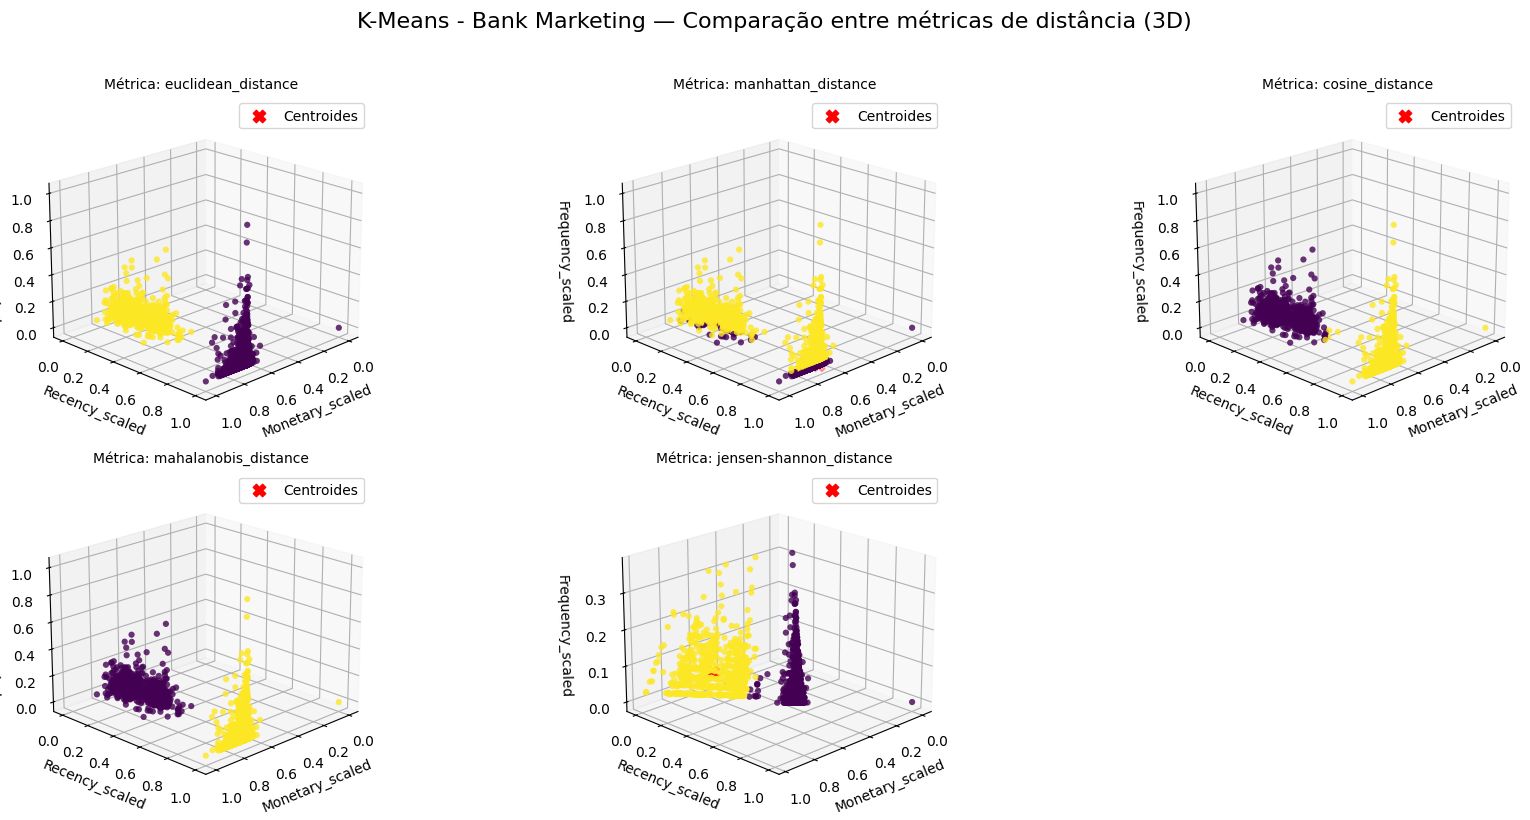

In [25]:
plot_algorithm_all_metrics_3d(plot_dict=plots_kmeans, algorithm_name="K-Means - Bank Marketing", x_index=2, y_index=0, z_index=1,
    n_cols=3, figsize=(18, 8), feature_names=['Recency_scaled', 'Frequency_scaled', 'Monetary_scaled'], elev=20, azim=45,
)

In [26]:
#results_kmeans.pop()
df_results_kmeans = pd.DataFrame(results_kmeans)
df_results_kmeans

,algorithm,internal_metric,n_clusters_found,runtime_sec,sse_euclidean,silhouette,davies_bouldin,calinski_harabasz
0,Kmeans,euclidean,2,0.156412,39.649049,0.875366,0.245667,42491.989427
1,Kmeans,manhattan,2,0.184934,363.479245,0.237684,2.105357,609.053506
2,Kmeans,cosine,2,0.288219,39.995147,0.874808,0.244498,42085.179693
3,Kmeans,mahalanobis,2,0.579881,39.649049,0.875366,0.245667,42491.989427
4,Kmeans,<function jensenshannon at 0x7f1b46f2b100>,2,1.737186,41.168025,0.872978,0.242966,40757.424904


In [ ]:
labels_k_means_euclidean = plots_kmeans['euclidean_distance']["labels"]
labels_k_means_manhattan = plots_kmeans['manhattan_distance']["labels"]
labels_k_means_cosine = plots_kmeans['cosine_distance']["labels"]
labels_k_means_mahalanobis = plots_kmeans['mahalanobis_distance']["labels"]
labels_k_means_jsd = plots_kmeans['jensen-shannon_distance']["labels"]

rfm_k_means = rfm_full.copy()
rfm_k_means[f"cluster_k_means_euclidean"] = labels_k_means_euclidean
rfm_k_means[f"cluster_k_means_manhattan"] = labels_k_means_manhattan
rfm_k_means[f"cluster_k_means_cosine"] = labels_k_means_cosine
rfm_k_means[f"cluster_k_means_mahalanobis"] = labels_k_means_mahalanobis
rfm_k_means[f"cluster_k_means_jsd"] = labels_k_means_jsd
rfm_k_means.head()

,Recency,Frequency,M_balance,R_norm,F_norm,M_norm,y,age,housing,marital,education,cluster_k_means_euclidean,cluster_k_means_manhattan,cluster_k_means_cosine,cluster_k_means_mahalanobis,cluster_k_means_jsd
0,872,1,8.537388,1.000000,0.000000,0.745264,0,30,0,married,primary,1,0,0,0,0
1,339,5,9.000113,0.388060,0.081633,0.789227,0,33,1,married,secondary,0,1,1,1,1
2,330,2,8.447843,0.377727,0.020408,0.736757,0,35,1,single,tertiary,0,0,1,1,1
3,872,4,8.474494,1.000000,0.061224,0.739289,0,30,1,married,tertiary,1,1,0,0,0
4,872,1,8.106213,1.000000,0.000000,0.704299,0,59,1,married,secondary,1,0,0,0,0


In [26]:
cluster_profile_kmeans_euclidean = (
    rfm_k_means
    .groupby("cluster_k_means_euclidean")
    .agg(
        n_contatos=("Recency", "size"),              # quantidade de linhas/contatos no cluster
        recency_media=("Recency", "mean"),
        recency_mediana=("Recency", "median"),
        freq_media=("Frequency", "mean"),
        freq_mediana=("Frequency", "median"),
        monetary_medio=("M_balance", "mean"),
        monetary_mediana=("M_balance", "median"),
        potencial_total=("M_balance", "sum"),          # soma do "M" do cluster
        taxa_conversao=("y", "mean"),          # proporção de y=1
        taxa_housing=("housing", "mean"), # proporção de clientes com housing=1
    )
    .sort_values("monetary_medio", ascending=False)
)

cluster_profile_kmeans_euclidean["perc_contatos"] = (
    cluster_profile_kmeans_euclidean["n_contatos"]
    / cluster_profile_kmeans_euclidean["n_contatos"].sum()
)

cluster_profile_kmeans_euclidean["perc_potencial"] = (
    cluster_profile_kmeans_euclidean["potencial_total"]
    / cluster_profile_kmeans_euclidean["potencial_total"].sum()
)

cluster_profile_kmeans_euclidean


,n_contatos,recency_media,recency_mediana,freq_media,freq_mediana,monetary_medio,monetary_mediana,potencial_total,taxa_conversao,taxa_housing,perc_contatos,perc_potencial
cluster_k_means_euclidean,,,,,,,,,,,,
0,809,220.274413,188.0,5.019778,4.0,8.409806,8.279951,6803.533296,0.223733,0.632880,0.178943,0.179838
1,3712,871.780172,872.0,2.969289,2.0,8.358822,8.224298,31027.949094,0.091595,0.551455,0.821057,0.820162


In [27]:
cluster_profile_k_means_manhattan = (
    rfm_k_means
    .groupby(f"cluster_k_means_manhattan")
    .agg(
        n_contatos=("Recency", "size"),              # quantidade de linhas/contatos no cluster
        recency_media=("Recency", "mean"),
        recency_mediana=("Recency", "median"),
        freq_media=("Frequency", "mean"),
        freq_mediana=("Frequency", "median"),
        monetary_medio=("M_balance", "mean"),
        monetary_mediana=("M_balance", "median"),
        potencial_total=("M_balance", "sum"),          # soma do "M" do cluster
        taxa_conversao=("y", "mean"),          # proporção de y=1
        taxa_housing=("housing", "mean"), # proporção de clientes com housing=1
    )
    .sort_values("monetary_medio", ascending=False)
)

cluster_profile_k_means_manhattan["perc_contatos"] = (
    cluster_profile_k_means_manhattan["n_contatos"]
    / cluster_profile_k_means_manhattan["n_contatos"].sum()
)

cluster_profile_k_means_manhattan["perc_potencial"] = (
    cluster_profile_k_means_manhattan["potencial_total"]
    / cluster_profile_k_means_manhattan["potencial_total"].sum()
)

cluster_profile_k_means_manhattan

,n_contatos,recency_media,recency_mediana,freq_media,freq_mediana,monetary_medio,monetary_mediana,potencial_total,taxa_conversao,taxa_housing,perc_contatos,perc_potencial
cluster_k_means_manhattan,,,,,,,,,,,,
1,1115,626.373991,872.0,7.612556,6.0,8.421934,8.287025,9390.456342,0.145291,0.565022,0.246627,0.248218
0,3406,797.370229,872.0,1.936289,2.0,8.350272,8.221748,28441.026048,0.105402,0.566353,0.753373,0.751782


In [28]:
cluster_profile_k_means_mahalanobis = (
    rfm_k_means
    .groupby(f"cluster_k_means_mahalanobis")
    .agg(
        n_contatos=("Recency", "size"),              # quantidade de linhas/contatos no cluster
        recency_media=("Recency", "mean"),
        recency_mediana=("Recency", "median"),
        freq_media=("Frequency", "mean"),
        freq_mediana=("Frequency", "median"),
        monetary_medio=("M_balance", "mean"),
        monetary_mediana=("M_balance", "median"),
        potencial_total=("M_balance", "sum"),          # soma do "M" do cluster
        taxa_conversao=("y", "mean"),          # proporção de y=1
        taxa_housing=("housing", "mean"), # proporção de clientes com housing=1
    )
    .sort_values("monetary_medio", ascending=False)
)

cluster_profile_k_means_mahalanobis["perc_contatos"] = (
    cluster_profile_k_means_mahalanobis["n_contatos"]
    / cluster_profile_k_means_mahalanobis["n_contatos"].sum()
)

cluster_profile_k_means_mahalanobis["perc_potencial"] = (
    cluster_profile_k_means_mahalanobis["potencial_total"]
    / cluster_profile_k_means_mahalanobis["potencial_total"].sum()
)

cluster_profile_k_means_mahalanobis

,n_contatos,recency_media,recency_mediana,freq_media,freq_mediana,monetary_medio,monetary_mediana,potencial_total,taxa_conversao,taxa_housing,perc_contatos,perc_potencial
cluster_k_means_mahalanobis,,,,,,,,,,,,
1,809,220.274413,188.0,5.019778,4.0,8.409806,8.279951,6803.533296,0.223733,0.632880,0.178943,0.179838
0,3712,871.780172,872.0,2.969289,2.0,8.358822,8.224298,31027.949094,0.091595,0.551455,0.821057,0.820162


In [29]:
cluster_profile_k_means_cosine = (
    rfm_k_means
    .groupby(f"cluster_k_means_cosine")
    .agg(
        n_contatos=("Recency", "size"),              # quantidade de linhas/contatos no cluster
        recency_media=("Recency", "mean"),
        recency_mediana=("Recency", "median"),
        freq_media=("Frequency", "mean"),
        freq_mediana=("Frequency", "median"),
        monetary_medio=("M_balance", "mean"),
        monetary_mediana=("M_balance", "median"),
        potencial_total=("M_balance", "sum"),          # soma do "M" do cluster
        taxa_conversao=("y", "mean"),          # proporção de y=1
        taxa_housing=("housing", "mean"), # proporção de clientes com housing=1
    )
    .sort_values("monetary_medio", ascending=False)
)

cluster_profile_k_means_cosine["perc_contatos"] = (
    cluster_profile_k_means_cosine["n_contatos"] 
    / cluster_profile_k_means_cosine["n_contatos"].sum()
)

cluster_profile_k_means_cosine["perc_potencial"] = (
    cluster_profile_k_means_cosine["potencial_total"] 
    / cluster_profile_k_means_cosine["potencial_total"].sum()
)

cluster_profile_k_means_cosine

,n_contatos,recency_media,recency_mediana,freq_media,freq_mediana,monetary_medio,monetary_mediana,potencial_total,taxa_conversao,taxa_housing,perc_contatos,perc_potencial
cluster_k_means_cosine,,,,,,,,,,,,
1,805,218.908075,188.0,5.024845,4.0,8.409926,8.279951,6769.990801,0.222360,0.633540,0.178058,0.178951
0,3716,871.374865,872.0,2.970398,2.0,8.358851,8.224432,31061.491590,0.092034,0.551399,0.821942,0.821049


In [30]:
cluster_profile_k_means_jsd = (
    rfm_k_means
    .groupby(f"cluster_k_means_jsd")
    .agg(
        n_contatos=("Recency", "size"),              # quantidade de linhas/contatos no cluster
        recency_media=("Recency", "mean"),
        recency_mediana=("Recency", "median"),
        freq_media=("Frequency", "mean"),
        freq_mediana=("Frequency", "median"),
        monetary_medio=("M_balance", "mean"),
        monetary_mediana=("M_balance", "median"),
        potencial_total=("M_balance", "sum"),          # soma do "M" do cluster
        taxa_conversao=("y", "mean"),          # proporção de y=1
        taxa_housing=("housing", "mean"), # proporção de clientes com housing=1
    )
    .sort_values("monetary_medio", ascending=False)
)

cluster_profile_k_means_jsd["perc_contatos"] = (
    cluster_profile_k_means_jsd["n_contatos"] 
    / cluster_profile_k_means_jsd["n_contatos"].sum()
)

cluster_profile_k_means_jsd["perc_potencial"] = (
    cluster_profile_k_means_jsd["potencial_total"] 
    / cluster_profile_k_means_jsd["potencial_total"].sum()
)

cluster_profile_k_means_jsd

,n_contatos,recency_media,recency_mediana,freq_media,freq_mediana,monetary_medio,monetary_mediana,potencial_total,taxa_conversao,taxa_housing,perc_contatos,perc_potencial
cluster_k_means_jsd,,,,,,,,,,,,
1,797,216.506901,186.0,5.046424,4.0,8.408921,8.278428,6701.909932,0.218319,0.633626,0.176288,0.177152
0,3724,870.487111,872.0,2.970193,2.0,8.359176,8.224967,31129.572459,0.093179,0.551557,0.823712,0.822848


### Algoritmo: Kmedoids

In [ ]:
results_kmedoids = []
plots_kmedoids = {}
# instaciando o KMedoids
for metric_name in metrics:
    kmedoids = KMedoids(k=2, max_iterations=300, metric_name=metric_name)
    if metric_name == 'jensen-shannon_distance':
        t0 = time()
        centroids_kmedoids, clusters_kmedoids = kmedoids.fit(X_jsd)
        runtime_kmedoids = time() - t0
        results_kmedoids.append(calculate_clustering_metrics(algorithm_name="KMedoids", metric_name=silhouette_metric_name[metric_name], runtime=runtime_kmedoids, X=X_jsd, labels=clusters_kmedoids))
        plots_kmedoids[metric_name] = {
            "X": X_jsd,
            "labels": clusters_kmedoids,
            "model": kmedoids
        }
    else:
        t0 = time()
        centroids_kmedoids, clusters_kmedoids = kmedoids.fit(X)
        runtime_kmedoids = time() - t0
        results_kmedoids.append(calculate_clustering_metrics(algorithm_name="KMedoids", metric_name=silhouette_metric_name[metric_name], runtime=runtime_kmedoids, X=X, labels=clusters_kmedoids))
        plots_kmedoids[metric_name] = {
            "X": X,
            "labels": clusters_kmedoids,
            "model": kmedoids
        }
    
    print(f"KMedoids com {metric_name} finalizado.")


K-Medoids convergiu na iteração 4
KMedoids com euclidean_distance finalizado.


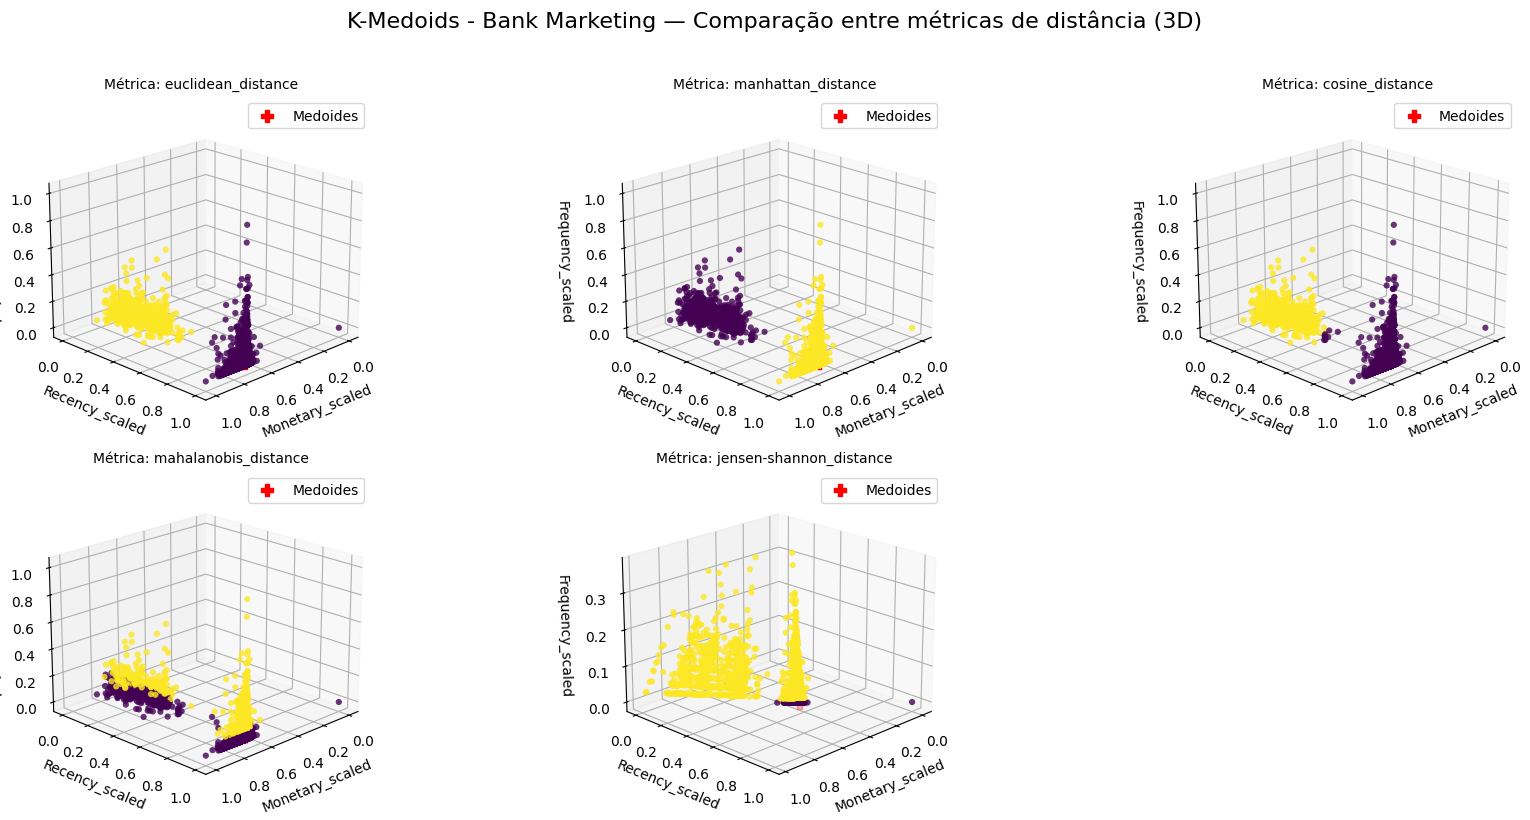

In [ ]:
plot_algorithm_all_metrics_3d(plot_dict=plots_kmedoids, algorithm_name="K-Medoids - Bank Marketing", x_index=2, y_index=0, z_index=1,
    n_cols=3, figsize=(18, 8), feature_names=['Recency_scaled', 'Frequency_scaled', 'Monetary_scaled'], elev=20, azim=45,
)

In [ ]:
results_kmedoids.pop(4)

{'algorithm': 'KMedoids',
 'internal_metric': 'mahalanobis_distance',
 'n_clusters_found': 2,
 'runtime_sec': 430.8860070705414,
 'sse_euclidean': np.float64(397.97732976775933),
 'silhouette': 0.303459111858838,
 'davies_bouldin': 3.3908461065925644,
 'calinski_harabasz': 164.53565711036293}

In [ ]:
#results_kmedoids.pop()
df_results_kmedoids = pd.DataFrame(results_kmedoids)
df_results_kmedoids

,algorithm,internal_metric,n_clusters_found,runtime_sec,sse_euclidean,silhouette,davies_bouldin,calinski_harabasz
0,KMedoids,cosine_distance,2,404.982285,40.480901,0.874025,0.243568,41525.948687
1,KMedoids,euclidean_distance,2,93.572531,39.649049,0.875366,0.245667,42491.989427
2,KMedoids,manhattan_distance,2,118.626397,39.649049,0.875366,0.245667,42491.989427
3,KMedoids,mahalanobis_distance,2,133.157390,39.649049,0.875366,0.245667,42491.989427


In [ ]:
labels_k_medoids_euclidean = plots_kmedoids['euclidean_distance']["labels"]
labels_k_medoids_manhattan = plots_kmedoids['manhattan_distance']["labels"]
labels_k_medoids_cosine = plots_kmedoids['cosine_distance']["labels"]
labels_k_medoids_mahalanobis = plots_kmedoids['mahalanobis_distance']["labels"]
labels_k_medoids_jsd = plots_kmedoids['jensen-shannon_distance']["labels"]

rfm_k_medoids = rfm_full.copy()
rfm_k_medoids[f"cluster_k_medoids_euclidean"] = labels_k_medoids_euclidean
rfm_k_medoids[f"cluster_k_medoids_manhattan"] = labels_k_medoids_manhattan
rfm_k_medoids[f"cluster_k_medoids_cosine"] = labels_k_medoids_cosine
rfm_k_medoids[f"cluster_k_medoids_mahalanobis"] = labels_k_medoids_mahalanobis
rfm_k_medoids[f"cluster_k_medoids_jsd"] = labels_k_medoids_jsd
rfm_k_medoids.head()



,Recency,Frequency,M_balance,R_norm,F_norm,M_norm,y,age,housing,marital,education,cluster_k_medoids_euclidean,cluster_k_medoids_manhattan,cluster_k_medoids_cosine,cluster_k_medoids_mahalanobis,cluster_k_medoids_jsd
0,872,1,8.537388,1.000000,0.000000,0.745264,0,30,0,married,primary,0,0,0,1,0
1,339,5,9.000113,0.388060,0.081633,0.789227,0,33,1,married,secondary,0,1,1,1,1
2,330,2,8.447843,0.377727,0.020408,0.736757,0,35,1,single,tertiary,1,0,1,0,1
3,872,4,8.474494,1.000000,0.061224,0.739289,0,30,1,married,tertiary,1,0,0,0,1
4,872,1,8.106213,1.000000,0.000000,0.704299,0,59,1,married,secondary,1,0,0,0,0


In [ ]:
cluster_profile_k_medoids_euclidean = (
    rfm_k_medoids
    .groupby(f"cluster_k_medoids_euclidean")
    .agg(
        n_contatos=("Recency", "size"),              # quantidade de linhas/contatos no cluster
        recency_media=("Recency", "mean"),
        recency_mediana=("Recency", "median"),
        freq_media=("Frequency", "mean"),
        freq_mediana=("Frequency", "median"),
        monetary_medio=("M_balance", "mean"),
        monetary_mediana=("M_balance", "median"),
        potencial_total=("M_balance", "sum"),          # soma do "M" do cluster
        taxa_conversao=("y", "mean"),          # proporção de y=1
        taxa_housing=("housing", "mean"), # proporção de clientes com housing=1
    )
    .sort_values("monetary_medio", ascending=False)
)

cluster_profile_k_medoids_euclidean["perc_contatos"] = (
    cluster_profile_k_medoids_euclidean["n_contatos"] 
    / cluster_profile_k_medoids_euclidean["n_contatos"].sum()
)

cluster_profile_k_medoids_euclidean["perc_potencial"] = (
    cluster_profile_k_medoids_euclidean["potencial_total"] 
    / cluster_profile_k_medoids_euclidean["potencial_total"].sum()
)

cluster_profile_k_medoids_euclidean

,n_contatos,recency_media,recency_mediana,freq_media,freq_mediana,monetary_medio,monetary_mediana,potencial_total,taxa_conversao,taxa_housing,perc_contatos,perc_potencial
cluster_k_medoids_euclidean,,,,,,,,,,,,
0,1005,738.762189,872.0,3.361194,2.0,8.945511,8.842604,8990.238977,0.156219,0.516418,0.222296,0.237639
1,3516,759.895904,872.0,3.329067,2.0,8.202856,8.178218,28841.243414,0.103527,0.580205,0.777704,0.762361


In [ ]:
cluster_profile_k_medoids_manhattan = (
    rfm_k_medoids
    .groupby(f"cluster_k_medoids_manhattan")
    .agg(
        n_contatos=("Recency", "size"),              # quantidade de linhas/contatos no cluster
        recency_media=("Recency", "mean"),
        recency_mediana=("Recency", "median"),
        freq_media=("Frequency", "mean"),
        freq_mediana=("Frequency", "median"),
        monetary_medio=("M_balance", "mean"),
        monetary_mediana=("M_balance", "median"),
        potencial_total=("M_balance", "sum"),          # soma do "M" do cluster
        taxa_conversao=("y", "mean"),          # proporção de y=1
        taxa_housing=("housing", "mean"), # proporção de clientes com housing=1
    )
    .sort_values("monetary_medio", ascending=False)
)

cluster_profile_k_medoids_manhattan["perc_contatos"] = (
    cluster_profile_k_medoids_manhattan["n_contatos"] 
    / cluster_profile_k_medoids_manhattan["n_contatos"].sum()
)

cluster_profile_k_medoids_manhattan["perc_potencial"] = (
    cluster_profile_k_medoids_manhattan["potencial_total"] 
    / cluster_profile_k_medoids_manhattan["potencial_total"].sum()
)

cluster_profile_k_medoids_manhattan

,n_contatos,recency_media,recency_mediana,freq_media,freq_mediana,monetary_medio,monetary_mediana,potencial_total,taxa_conversao,taxa_housing,perc_contatos,perc_potencial
cluster_k_medoids_manhattan,,,,,,,,,,,,
0,3393,794.025936,872.0,1.928382,2.0,8.381375,8.248006,28438.005593,0.112585,0.566166,0.750498,0.751702
1,1128,638.404255,872.0,7.570922,6.0,8.327550,8.188967,9393.476798,0.123227,0.565603,0.249502,0.248298


In [ ]:
cluster_profile_k_medoids_cosine = (
    rfm_k_medoids
    .groupby(f"cluster_k_medoids_cosine")
    .agg(
        n_contatos=("Recency", "size"),              # quantidade de linhas/contatos no cluster
        recency_media=("Recency", "mean"),
        recency_mediana=("Recency", "median"),
        freq_media=("Frequency", "mean"),
        freq_mediana=("Frequency", "median"),
        monetary_medio=("M_balance", "mean"),
        monetary_mediana=("M_balance", "median"),
        potencial_total=("M_balance", "sum"),          # soma do "M" do cluster
        taxa_conversao=("y", "mean"),          # proporção de y=1
        taxa_housing=("housing", "mean"), # proporção de clientes com housing=1
    )
    .sort_values("monetary_medio", ascending=False)
)

cluster_profile_k_medoids_cosine["perc_contatos"] = (
    cluster_profile_k_medoids_cosine["n_contatos"] 
    / cluster_profile_k_medoids_cosine["n_contatos"].sum()
)

cluster_profile_k_medoids_cosine["perc_potencial"] = (
    cluster_profile_k_medoids_cosine["potencial_total"] 
    / cluster_profile_k_medoids_cosine["potencial_total"].sum()
)

cluster_profile_k_medoids_cosine

,n_contatos,recency_media,recency_mediana,freq_media,freq_mediana,monetary_medio,monetary_mediana,potencial_total,taxa_conversao,taxa_housing,perc_contatos,perc_potencial
cluster_k_medoids_cosine,,,,,,,,,,,,
1,801,217.637953,187.0,5.034956,4.0,8.409264,8.278682,6735.820470,0.219725,0.632959,0.177173,0.178048
0,3720,870.946774,872.0,2.970430,2.0,8.359049,8.224700,31095.661921,0.092742,0.551613,0.822827,0.821952


In [ ]:
cluster_profile_k_medoids_mahalanobis= (
    rfm_k_medoids
    .groupby(f"cluster_k_medoids_mahalanobis")
    .agg(
        n_contatos=("Recency", "size"),              # quantidade de linhas/contatos no cluster
        recency_media=("Recency", "mean"),
        recency_mediana=("Recency", "median"),
        freq_media=("Frequency", "mean"),
        freq_mediana=("Frequency", "median"),
        monetary_medio=("M_balance", "mean"),
        monetary_mediana=("M_balance", "median"),
        potencial_total=("M_balance", "sum"),          # soma do "M" do cluster
        taxa_conversao=("y", "mean"),          # proporção de y=1
        taxa_housing=("housing", "mean"), # proporção de clientes com housing=1
    )
    .sort_values("monetary_medio", ascending=False)
)

cluster_profile_k_medoids_mahalanobis["perc_contatos"] = (
    cluster_profile_k_medoids_mahalanobis["n_contatos"] 
    / cluster_profile_k_medoids_mahalanobis["n_contatos"].sum()
)

cluster_profile_k_medoids_mahalanobis["perc_potencial"] = (
    cluster_profile_k_medoids_mahalanobis["potencial_total"] 
    / cluster_profile_k_medoids_mahalanobis["potencial_total"].sum()
)

cluster_profile_k_medoids_mahalanobis

,n_contatos,recency_media,recency_mediana,freq_media,freq_mediana,monetary_medio,monetary_mediana,potencial_total,taxa_conversao,taxa_housing,perc_contatos,perc_potencial
cluster_k_medoids_mahalanobis,,,,,,,,,,,,
1,1004,751.925299,872.0,3.339641,2.0,8.945225,8.842821,8981.005674,0.150398,0.518924,0.222075,0.237395
0,3517,756.132215,872.0,3.335229,2.0,8.203149,8.178358,28850.476717,0.105203,0.579471,0.777925,0.762605


In [ ]:
cluster_profile_k_medoids_jsd = (
    rfm_k_medoids
    .groupby(f"cluster_k_medoids_jsd")
    .agg(
        n_contatos=("Recency", "size"),              # quantidade de linhas/contatos no cluster
        recency_media=("Recency", "mean"),
        recency_mediana=("Recency", "median"),
        freq_media=("Frequency", "mean"),
        freq_mediana=("Frequency", "median"),
        monetary_medio=("M_balance", "mean"),
        monetary_mediana=("M_balance", "median"),
        potencial_total=("M_balance", "sum"),          # soma do "M" do cluster
        taxa_conversao=("y", "mean"),          # proporção de y=1
        taxa_housing=("housing", "mean"), # proporção de clientes com housing=1
    )
    .sort_values("monetary_medio", ascending=False)
)

cluster_profile_k_medoids_jsd["perc_contatos"] = (
    cluster_profile_k_medoids_jsd["n_contatos"] 
    / cluster_profile_k_medoids_jsd["n_contatos"].sum()
)

cluster_profile_k_medoids_jsd["perc_potencial"] = (
    cluster_profile_k_medoids_jsd["potencial_total"] 
    / cluster_profile_k_medoids_jsd["potencial_total"].sum()
)

cluster_profile_k_medoids_jsd


,n_contatos,recency_media,recency_mediana,freq_media,freq_mediana,monetary_medio,monetary_mediana,potencial_total,taxa_conversao,taxa_housing,perc_contatos,perc_potencial
cluster_k_medoids_jsd,,,,,,,,,,,,
1,2154,626.877437,872.0,5.412256,4.0,8.375375,8.233901,18040.55687,0.133240,0.572888,0.476443,0.476866
0,2367,871.971272,872.0,1.446979,1.0,8.361185,8.229511,19790.92552,0.098859,0.559780,0.523557,0.523134


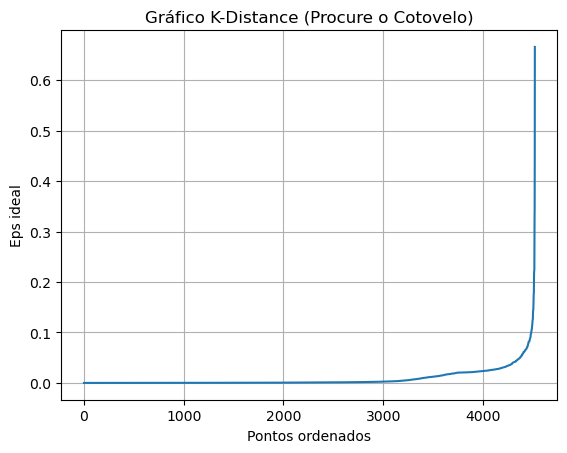

In [ ]:
from sklearn.neighbors import NearestNeighbors

# Calcula a distância para o vizinho mais próximo (k=min_samples)
min_samples = 10 # Mesmo valor que você usará no DBSCAN
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)

# Ordena e plota
distances = np.sort(distances[:, min_samples-1], axis=0)
plt.plot(distances)
plt.title("Gráfico K-Distance (Procure o Cotovelo)")
plt.ylabel("Eps ideal")
plt.xlabel("Pontos ordenados")
plt.grid(True)
plt.show()

/root/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


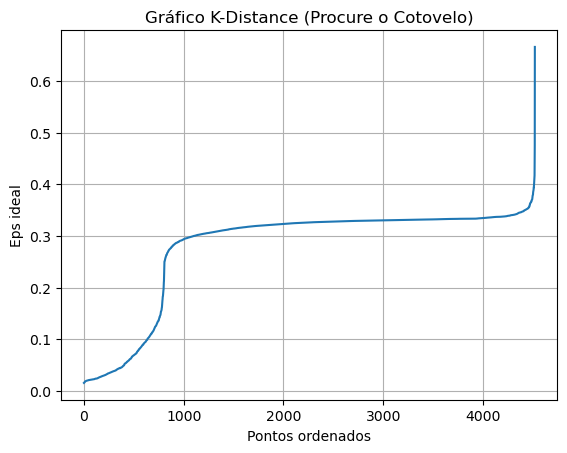

In [ ]:
# Calcula a distância para o vizinho mais próximo (k=min_samples)
min_samples = 10 # Mesmo valor que você usará no DBSCAN
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X_jsd)

# Ordena e plota
distances = np.sort(distances[:, min_samples-1], axis=0)
plt.plot(distances)
plt.title("Gráfico K-Distance (Procure o Cotovelo)")
plt.ylabel("Eps ideal")
plt.xlabel("Pontos ordenados")
plt.grid(True)
plt.show()

In [29]:
#Estudo do melhor eps para DBSCAN com Euclidean Distance

eval_kwargs = {}
eps = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.10, 0.12, 0.15, 0.18, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65]
results_eps = []
for ep in eps:
    db = DBSCAN(eps=ep, min_samples=10, metric='euclidean_distance')
    db.fit(X)
    k = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
    eval_kwargs = {}
    evaluation = EvaluationMetrics(X=X, labels=db.labels_, y_true=None, metric=silhouette_metric_name['euclidean_distance'], **eval_kwargs)
    sil = evaluation.silhouette()
    sse = evaluation.sse_euclidean()
    results_eps.append({"k": k,
        "sse_euclidean": sse,
        "silhouette": sil,
        "algoritmo": "DBSCAN",
        "eps": ep,
        "metric": "euclidean_distance"
    })
    print(f"DBSCAN com eps {ep} finalizado.")

DBSCAN com eps 0.01 finalizado.
DBSCAN com eps 0.02 finalizado.
DBSCAN com eps 0.03 finalizado.
DBSCAN com eps 0.04 finalizado.
DBSCAN com eps 0.05 finalizado.
DBSCAN com eps 0.06 finalizado.
DBSCAN com eps 0.07 finalizado.
DBSCAN com eps 0.08 finalizado.
DBSCAN com eps 0.09 finalizado.
DBSCAN com eps 0.1 finalizado.
DBSCAN com eps 0.12 finalizado.
DBSCAN com eps 0.15 finalizado.
DBSCAN com eps 0.18 finalizado.
DBSCAN com eps 0.2 finalizado.
DBSCAN com eps 0.25 finalizado.
DBSCAN com eps 0.3 finalizado.
DBSCAN com eps 0.35 finalizado.
DBSCAN com eps 0.4 finalizado.
DBSCAN com eps 0.45 finalizado.
DBSCAN com eps 0.5 finalizado.
DBSCAN com eps 0.55 finalizado.
DBSCAN com eps 0.6 finalizado.
DBSCAN com eps 0.65 finalizado.


In [31]:
df_results_eps = pd.DataFrame(results_eps)
df_results_eps

,k,sse_euclidean,silhouette,algoritmo,eps,metric
0,17,2.811343,0.050991,DBSCAN,0.01,euclidean_distance
1,30,3.968613,0.116874,DBSCAN,0.02,euclidean_distance
2,2,23.651543,0.791202,DBSCAN,0.03,euclidean_distance
3,2,25.477581,0.810519,DBSCAN,0.04,euclidean_distance
4,2,28.928255,0.820886,DBSCAN,0.05,euclidean_distance
5,2,30.883154,0.836548,DBSCAN,0.06,euclidean_distance
6,2,32.639817,0.841357,DBSCAN,0.07,euclidean_distance
7,2,33.256214,0.850973,DBSCAN,0.08,euclidean_distance
8,2,35.479734,0.852331,DBSCAN,0.09,euclidean_distance
9,2,35.699303,0.852497,DBSCAN,0.10,euclidean_distance


In [ ]:
#Estudo do melhor eps para DBSCAN com Euclidean Distance

eval_kwargs = {}
eps = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.10, 0.12, 0.15, 0.18, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65]
results_eps_jsd = []
for ep in eps:
    db = DBSCAN(eps=ep, min_samples=10, metric='jensen-shannon_distance')
    db.fit(X_jsd)
    k = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
    eval_kwargs = {}
    evaluation = EvaluationMetrics(X=X_jsd, labels=db.labels_, y_true=None, metric=silhouette_metric_name['jensen-shannon_distance'], **eval_kwargs)
    sil = evaluation.silhouette()
    sse = evaluation.sse_euclidean()
    results_eps_jsd.append({"k": k,
        "sse_euclidean": sse,
        "silhouette": sil,
        "algoritmo": "DBSCAN",
        "eps": ep,
        "metric": "jensen-shannon_distance"
    })
    print(f"DBSCAN com eps {ep} finalizado.")

In [ ]:
df_results_eps_jsd = pd.DataFrame(results_eps_jsd)
df_results_eps_jsd

### Algoritmo: DBSCAN

In [ ]:
results_dbscan = []
plots_dbscan = {}
# instaciando o DBSCAN
for metric_name in metrics:
    dbscan = DBSCAN(eps=0.03, min_samples=10, metric=metric_name)
    if metric_name == 'jensen-shannon_distance':
        t0 = time()
        dbscan.fit(X_jsd)
        runtime_dbscan = time() - t0
        labels_dbscan = dbscan.labels_
        results_dbscan.append(calculate_clustering_metrics(algorithm_name="DBSCAN", metric_name=silhouette_metric_name[metric_name], runtime=runtime_dbscan, X=X_jsd, labels=labels_dbscan))
        plots_dbscan[metric_name] = {
            "X": X_jsd,
            "labels": labels_dbscan,
            "model": dbscan
        }
    else:
        t0 = time()
        dbscan.fit(X)
        runtime_dbscan = time() - t0
        labels_dbscan = dbscan.labels_
        results_dbscan.append(calculate_clustering_metrics(algorithm_name="DBSCAN", metric_name=silhouette_metric_name[metric_name], runtime=runtime_dbscan, X=X, labels=labels_dbscan))
        plots_dbscan[metric_name] = {
            "X": X,
            "labels": labels_dbscan,
            "model": dbscan
        }
    
    print(f"dbscan com {metric_name} finalizado.")

KMeans com euclidean_distance finalizado.
KMeans com manhattan_distance finalizado.
KMeans com cosine_distance finalizado.
KMeans com mahalanobis_distance finalizado.
KMeans com jensen-shannon_distance finalizado.


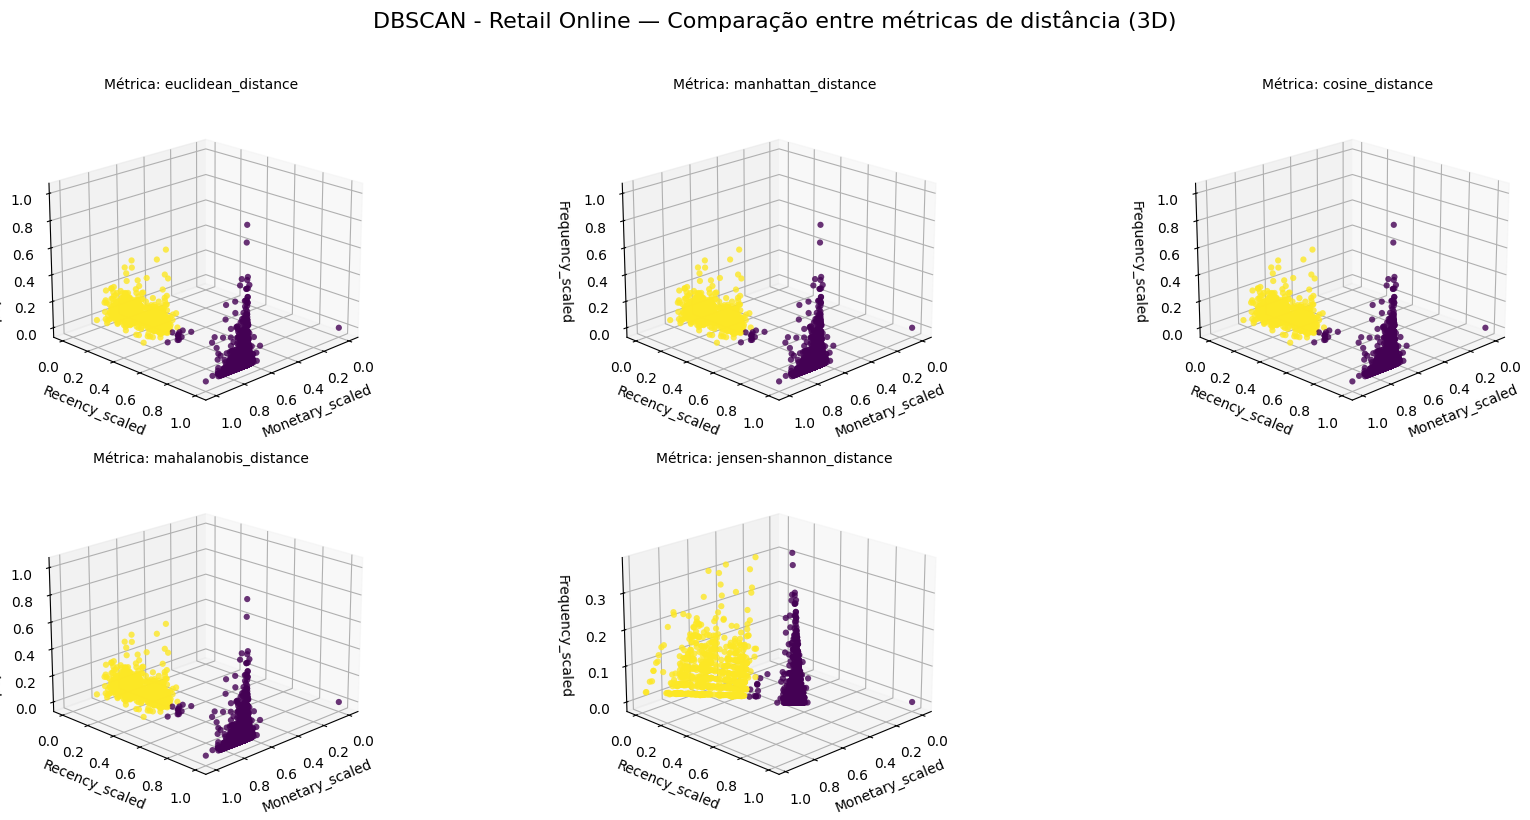

In [37]:
plot_algorithm_all_metrics_3d(plot_dict=plots_kmeans, algorithm_name="DBSCAN - Retail Online", x_index=2, y_index=0, z_index=1,
    n_cols=3, figsize=(18, 8), feature_names=['Recency_scaled', 'Frequency_scaled', 'Monetary_scaled'], elev=20, azim=45,
)

In [46]:
#results_dbscan.pop()
results_dbscan = results_kmeans[5:10]
df_results_dbscan = pd.DataFrame(results_dbscan)
df_results_dbscan



,algorithm,internal_metric,n_clusters_found,runtime_sec,sse_euclidean,silhouette,davies_bouldin,calinski_harabasz
0,DBSCAN,euclidean,2,1.737186,41.168025,0.872978,0.242966,40757.424904
1,DBSCAN,manhattan,2,1.737186,41.168025,0.872978,0.242966,40757.424904
2,DBSCAN,cosine,2,1.737186,41.168025,0.872978,0.242966,40757.424904
3,DBSCAN,mahalanobis,2,1.737186,41.168025,0.872978,0.242966,40757.424904
4,DBSCAN,<function jensenshannon at 0x7f1b46f2b100>,2,1.737186,23.136173,0.848920,0.346181,25928.627218


In [47]:
labels_dbscan_euclidean = plots_dbscan['euclidean_distance']["labels"]
labels_dbscan_manhattan = plots_dbscan['manhattan_distance']["labels"]
labels_dbscan_cosine = plots_dbscan['cosine_distance']["labels"]
labels_dbscan_mahalanobis = plots_dbscan['mahalanobis_distance']["labels"]
labels_dbscan_jsd = plots_dbscan['jensen-shannon_distance']["labels"]

rfm_dbscan = rfm_full.copy()
rfm_dbscan[f"cluster_dbscan_euclidean"] = labels_dbscan_euclidean
rfm_dbscan[f"cluster_dbscan_manhattan"] = labels_dbscan_manhattan
rfm_dbscan[f"cluster_dbscan_cosine"] = labels_dbscan_cosine
rfm_dbscan[f"cluster_dbscan_mahalanobis"] = labels_dbscan_mahalanobis
rfm_dbscan[f"cluster_dbscan_jsd"] = labels_dbscan_jsd
rfm_dbscan.head()


KeyError: 'euclidean_distance'

In [ ]:
cluster_profile_dbscan_euclidean = (
    rfm_dbscan
    .groupby(f"cluster_dbscan_euclidean")
    .agg(
        n_contatos=("Recency", "size"),              # quantidade de linhas/contatos no cluster
        recency_media=("Recency", "mean"),
        recency_mediana=("Recency", "median"),
        freq_media=("Frequency", "mean"),
        freq_mediana=("Frequency", "median"),
        monetary_medio=("M_balance", "mean"),
        monetary_mediana=("M_balance", "median"),
        potencial_total=("M_balance", "sum"),          # soma do "M" do cluster
        taxa_conversao=("y", "mean"),          # proporção de y=1
        taxa_housing=("housing", "mean"), # proporção de clientes com housing=1
    )
    .sort_values("monetary_medio", ascending=False)
)

cluster_profile_dbscan_euclidean["perc_contatos"] = (
    cluster_profile_dbscan_euclidean["n_contatos"] 
    / cluster_profile_dbscan_euclidean["n_contatos"].sum()
)

cluster_profile_dbscan_euclidean["perc_potencial"] = (
    cluster_profile_dbscan_euclidean["potencial_total"] 
    / cluster_profile_dbscan_euclidean["potencial_total"].sum()
)

cluster_profile_dbscan_euclidean

,n_contatos,recency_media,recency_mediana,freq_media,freq_mediana,monetary_medio,monetary_mediana,potencial_total,taxa_conversao,taxa_housing,perc_contatos,perc_potencial
cluster_dbscan_euclidean,,,,,,,,,,,,
2,807,219.928129,188.0,4.956629,4.0,8.409690,8.279951,6786.619749,0.224287,0.631970,0.178500,0.179391
1,3709,871.779995,872.0,2.946077,2.0,8.360975,8.224432,31010.856351,0.091669,0.551092,0.820394,0.819710
-1,5,667.200000,872.0,31.200000,32.0,6.801258,8.194229,34.006290,0.000000,1.000000,0.001106,0.000899


In [ ]:
cluster_profile_dbscan_manhattan = (
    rfm_dbscan
    .groupby(f"cluster_dbscan_manhattan")
    .agg(
        n_contatos=("Recency", "size"),              # quantidade de linhas/contatos no cluster
        recency_media=("Recency", "mean"),
        recency_mediana=("Recency", "median"),
        freq_media=("Frequency", "mean"),
        freq_mediana=("Frequency", "median"),
        monetary_medio=("M_balance", "mean"),
        monetary_mediana=("M_balance", "median"),
        potencial_total=("M_balance", "sum"),          # soma do "M" do cluster
        taxa_conversao=("y", "mean"),          # proporção de y=1
        taxa_housing=("housing", "mean"), # proporção de clientes com housing=1
    )
    .sort_values("monetary_medio", ascending=False)
)

cluster_profile_dbscan_manhattan["perc_contatos"] = (
    cluster_profile_dbscan_manhattan["n_contatos"] 
    / cluster_profile_dbscan_manhattan["n_contatos"].sum()
)

cluster_profile_dbscan_manhattan["perc_potencial"] = (
    cluster_profile_dbscan_manhattan["potencial_total"] 
    / cluster_profile_dbscan_manhattan["potencial_total"].sum()
)

cluster_profile_dbscan_manhattan

,n_contatos,recency_media,recency_mediana,freq_media,freq_mediana,monetary_medio,monetary_mediana,potencial_total,taxa_conversao,taxa_housing,perc_contatos,perc_potencial
cluster_dbscan_manhattan,,,,,,,,,,,,
2,807,220.560099,188.0,4.934325,4.0,8.409280,8.278936,6786.288862,0.225527,0.630731,0.178500,0.179382
1,3708,871.830906,872.0,2.944984,2.0,8.361002,8.224432,31002.594566,0.091424,0.551241,0.820173,0.819492
-1,6,584.833333,619.5,30.166667,30.5,7.099827,8.203263,42.598962,0.000000,1.000000,0.001327,0.001126


In [ ]:
cluster_profile_dbscan_cosine = (
    rfm_dbscan
    .groupby(f"cluster_dbscan_cosine")
    .agg(
        n_contatos=("Recency", "size"),              # quantidade de linhas/contatos no cluster
        recency_media=("Recency", "mean"),
        recency_mediana=("Recency", "median"),
        freq_media=("Frequency", "mean"),
        freq_mediana=("Frequency", "median"),
        monetary_medio=("M_balance", "mean"),
        monetary_mediana=("M_balance", "median"),
        potencial_total=("M_balance", "sum"),          # soma do "M" do cluster
        taxa_conversao=("y", "mean"),          # proporção de y=1
        taxa_housing=("housing", "mean"), # proporção de clientes com housing=1
    )
    .sort_values("monetary_medio", ascending=False)
)

cluster_profile_dbscan_cosine["perc_contatos"] = (
    cluster_profile_dbscan_cosine["n_contatos"] 
    / cluster_profile_dbscan_cosine["n_contatos"].sum()
)

cluster_profile_dbscan_cosine["perc_potencial"] = (
    cluster_profile_dbscan_cosine["potencial_total"] 
    / cluster_profile_dbscan_cosine["potencial_total"].sum()
)

cluster_profile_dbscan_cosine

In [ ]:
cluster_profile_dbscan_mahalanobis = (
    rfm_dbscan
    .groupby(f"cluster_dbscan_mahalanobis")
    .agg(
        n_contatos=("Recency", "size"),              # quantidade de linhas/contatos no cluster
        recency_media=("Recency", "mean"),
        recency_mediana=("Recency", "median"),
        freq_media=("Frequency", "mean"),
        freq_mediana=("Frequency", "median"),
        monetary_medio=("M_balance", "mean"),
        monetary_mediana=("M_balance", "median"),
        potencial_total=("M_balance", "sum"),          # soma do "M" do cluster
        taxa_conversao=("y", "mean"),          # proporção de y=1
        taxa_housing=("housing", "mean"), # proporção de clientes com housing=1
    )
    .sort_values("monetary_medio", ascending=False)
)

cluster_profile_dbscan_mahalanobis["perc_contatos"] = (
    cluster_profile_dbscan_mahalanobis["n_contatos"] 
    / cluster_profile_dbscan_mahalanobis["n_contatos"].sum()
)

cluster_profile_dbscan_mahalanobis["perc_potencial"] = (
    cluster_profile_dbscan_mahalanobis["potencial_total"] 
    / cluster_profile_dbscan_mahalanobis["potencial_total"].sum()
)

cluster_profile_dbscan_mahalanobis

,n_contatos,recency_media,recency_mediana,freq_media,freq_mediana,monetary_medio,monetary_mediana,potencial_total,taxa_conversao,taxa_housing,perc_contatos,perc_potencial
cluster_dbscan_mahalanobis,,,,,,,,,,,,
14,10,872.000000,872.0,1.000000,1.0,9.589542,9.587440,95.895416,0.100000,0.500000,0.002212,0.002535
23,10,872.000000,872.0,6.000000,6.0,8.991340,8.991676,89.913400,0.100000,0.400000,0.002212,0.002377
21,12,872.000000,872.0,5.000000,5.0,8.826634,8.830927,105.919606,0.000000,0.666667,0.002654,0.002800
-1,788,447.275381,320.0,7.211929,6.0,8.637578,8.488073,6806.411237,0.199239,0.581218,0.174298,0.179914
4,1036,872.000000,872.0,2.000000,2.0,8.344245,8.219461,8644.638284,0.092664,0.533784,0.229153,0.228504
1,1277,872.000000,872.0,1.000000,1.0,8.329025,8.229244,10636.165363,0.103367,0.581049,0.282460,0.281146
6,450,871.997778,872.0,3.000000,3.0,8.321659,8.218787,3744.746480,0.073333,0.551111,0.099536,0.098985
24,9,102.666667,97.0,5.000000,5.0,8.292369,8.273081,74.631317,0.333333,0.555556,0.001991,0.001973
2,268,872.000000,872.0,4.000000,4.0,8.287353,8.198089,2221.010513,0.119403,0.522388,0.059279,0.058708


In [ ]:
cluster_profile_dbscan_jsd = (
    rfm_dbscan
    .groupby(f"cluster_dbscan_jsd")
    .agg(
        n_contatos=("Recency", "size"),              # quantidade de linhas/contatos no cluster
        recency_media=("Recency", "mean"),
        recency_mediana=("Recency", "median"),
        freq_media=("Frequency", "mean"),
        freq_mediana=("Frequency", "median"),
        monetary_medio=("M_balance", "mean"),
        monetary_mediana=("M_balance", "median"),
        potencial_total=("M_balance", "sum"),          # soma do "M" do cluster
        taxa_conversao=("y", "mean"),          # proporção de y=1
        taxa_housing=("housing", "mean"), # proporção de clientes com housing=1
    )
    .sort_values("monetary_medio", ascending=False)
)

cluster_profile_dbscan_jsd["perc_contatos"] = (
    cluster_profile_dbscan_jsd["n_contatos"] 
    / cluster_profile_dbscan_jsd["n_contatos"].sum()
)

cluster_profile_dbscan_jsd["perc_potencial"] = (
    cluster_profile_dbscan_jsd["potencial_total"] 
    / cluster_profile_dbscan_jsd["potencial_total"].sum()
)

cluster_profile_dbscan_jsd

,n_contatos,recency_media,recency_mediana,freq_media,freq_mediana,monetary_medio,monetary_mediana,potencial_total,taxa_conversao,taxa_housing,perc_contatos,perc_potencial
cluster_dbscan_jsd,,,,,,,,,,,,
2,3194,711.045711,872.0,4.246713,3.0,8.373194,8.230844,26743.982681,0.120225,0.559800,0.706481,0.706924
1,1308,872.000000,872.0,1.000000,1.0,8.361919,8.234963,10937.389972,0.103211,0.581804,0.289317,0.289108
-1,19,136.526316,3.0,11.105263,6.0,7.900513,8.194229,150.109738,0.105263,0.526316,0.004203,0.003968


### Algoritmo: EM

In [ ]:
results_em = []
plots_em = {}
# instaciando the Expectation Maximization
for metric_name in metrics:
    em = ExpectationMaximization(n_clusters=2, max_iterations=10000, metric_name=metric_name)
    if metric_name == 'jensen-shannon_distance':
        t0 = time()
        em.fit(X_jsd)
        runtime_em = time() - t0
        labels_em = em.labels_
        results_em.append(calculate_clustering_metrics(algorithm_name="Expectation Maximization", metric_name=silhouette_metric_name[metric_name], runtime=runtime_em, X=X_jsd, labels=labels_em))
        plots_em[metric_name] = {
            "X": X_jsd,
            "labels": labels_em,
            "model": em
        }
    else:
        t0 = time()
        em.fit(X)
        runtime_em = time() - t0
        labels_em = em.labels_
        results_em.append(calculate_clustering_metrics(algorithm_name="Expectation Maximization", metric_name=silhouette_metric_name[metric_name], runtime=runtime_em, X=X, labels=labels_em))
        plots_em[metric_name] = {
            "X": X,
            "labels": labels_em,
            "model": em
        }
    print(f"Expectation Maximization com métrica {metric_name} finalizado.")



/root/jane-oliveira/tcc-git/clustering-client-segmentation-tcc/src/expectationmaximization.py:69: UserWarning: ExpectationMaximization: com métricas diferentes de 'mahalanobis_distance', o algoritmo deixa de ser um GMM probabilisticamente consistente e passa a ser uma variante experimental de soft-clustering baseada em distância.
  warnings.warn(


Expectation Maximization com métrica euclidean_distance finalizado.
Expectation Maximization com métrica manhattan_distance finalizado.
Expectation Maximization com métrica cosine_distance finalizado.
Expectation Maximization com métrica mahalanobis_distance finalizado.


/root/jane-oliveira/tcc-git/clustering-client-segmentation-tcc/src/expectationmaximization.py:69: UserWarning: ExpectationMaximization: com métricas diferentes de 'mahalanobis_distance', o algoritmo deixa de ser um GMM probabilisticamente consistente e passa a ser uma variante experimental de soft-clustering baseada em distância.
  warnings.warn(


Expectation Maximization com métrica jensen-shannon_distance finalizado.


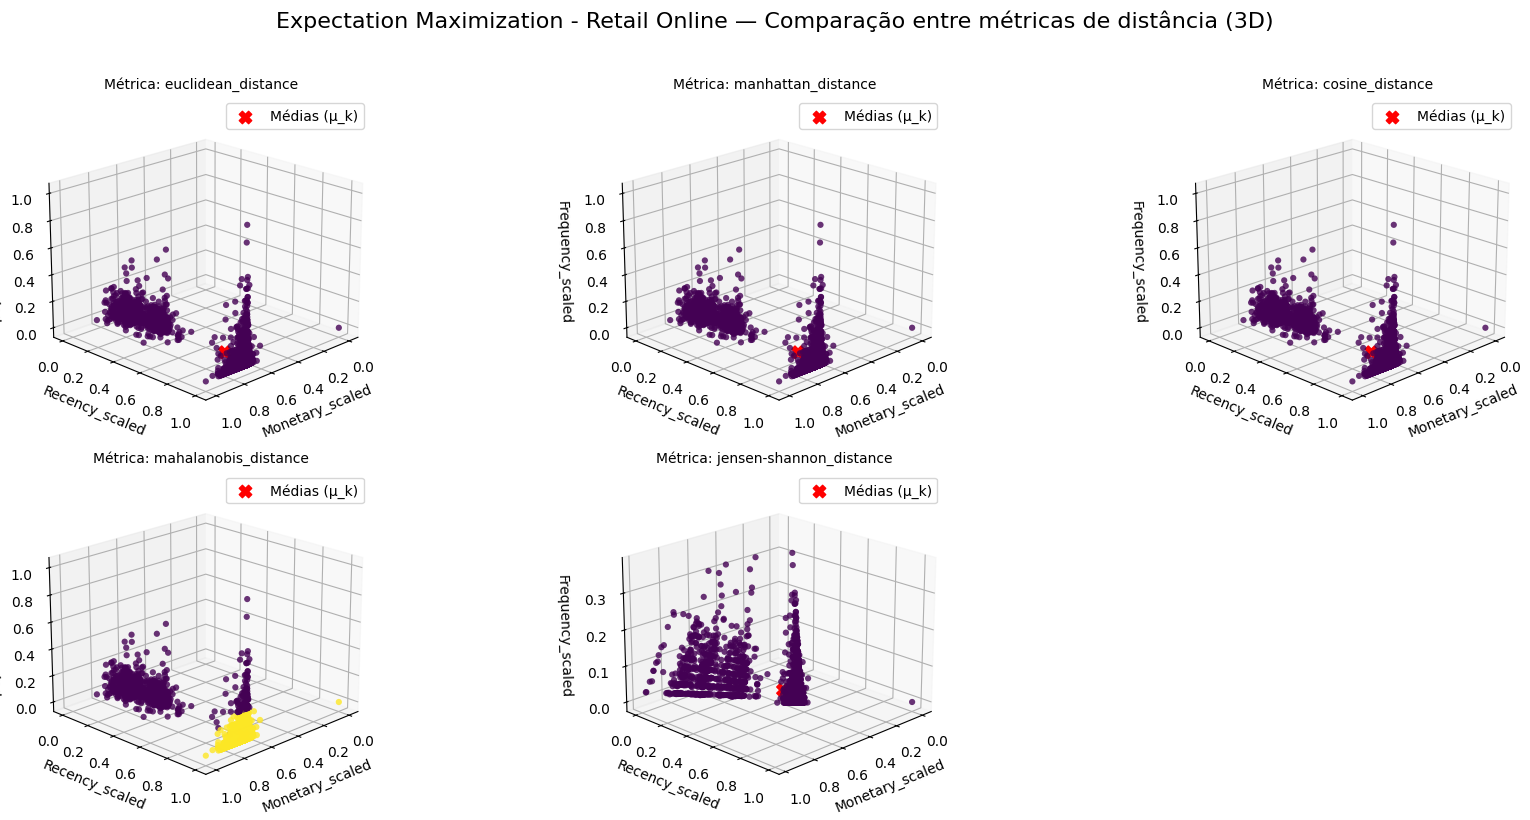

In [ ]:
plot_algorithm_all_metrics_3d(plot_dict=plots_em, algorithm_name="Expectation Maximization - Retail Online", x_index=2, y_index=0, z_index=1,
    n_cols=3, figsize=(18, 8), feature_names=['Recency_scaled', 'Frequency_scaled', 'Monetary_scaled'], elev=20, azim=45,
)

In [ ]:
#results_em.pop()
df_results_em = pd.DataFrame(results_em)
df_results_em

,algorithm,internal_metric,n_clusters_found,runtime_sec,sse_euclidean,silhouette,davies_bouldin,calinski_harabasz
0,Expectation Maximization,euclidean_distance,1,0.375590,412.467585,NaN,NaN,NaN
1,Expectation Maximization,manhattan_distance,1,0.419799,412.467585,NaN,NaN,NaN
2,Expectation Maximization,cosine_distance,1,0.270521,412.467585,NaN,NaN,NaN
3,Expectation Maximization,mahalanobis_distance,2,0.049258,90.793760,0.829196,0.402574,16010.395556
4,Expectation Maximization,jensen-shannon_distance,1,1.662444,155.884390,NaN,NaN,NaN


In [ ]:
labels_em_euclidean = plots_em['euclidean_distance']["labels"]
labels_em_manhattan = plots_em['manhattan_distance']["labels"]
labels_em_cosine = plots_em['cosine_distance']["labels"]
labels_em_mahalanobis = plots_em['mahalanobis_distance']["labels"]
labels_em_jsd = plots_em['jensen-shannon_distance']["labels"]

rfm_em = rfm_full.copy()
rfm_em[f"cluster_em_euclidean"] = labels_em_euclidean
rfm_em[f"cluster_em_manhattan"] = labels_em_manhattan
rfm_em[f"cluster_em_cosine"] = labels_em_cosine
rfm_em[f"cluster_em_mahalanobis"] = labels_em_mahalanobis
rfm_em[f"cluster_em_jsd"] = labels_em_jsd
rfm_em.head()

,Recency,Frequency,M_balance,R_norm,F_norm,M_norm,y,age,housing,marital,education,cluster_em_euclidean,cluster_em_manhattan,cluster_em_cosine,cluster_em_mahalanobis,cluster_em_jsd
0,872,1,8.537388,1.000000,0.000000,0.745264,0,30,0,married,primary,0,1,0,0,1
1,339,5,9.000113,0.388060,0.081633,0.789227,0,33,1,married,secondary,0,1,0,1,1
2,330,2,8.447843,0.377727,0.020408,0.736757,0,35,1,single,tertiary,0,1,0,1,1
3,872,4,8.474494,1.000000,0.061224,0.739289,0,30,1,married,tertiary,0,1,0,0,1
4,872,1,8.106213,1.000000,0.000000,0.704299,0,59,1,married,secondary,0,1,0,0,1


In [ ]:
cluster_profile_em_mahalanobis = (
    rfm_em
    .groupby(f"cluster_em_mahalanobis")
    .agg(
        n_contatos=("Recency", "size"),              # quantidade de linhas/contatos no cluster
        recency_media=("Recency", "mean"),
        recency_mediana=("Recency", "median"),
        freq_media=("Frequency", "mean"),
        freq_mediana=("Frequency", "median"),
        monetary_medio=("M_balance", "mean"),
        monetary_mediana=("M_balance", "median"),
        potencial_total=("M_balance", "sum"),          # soma do "M" do cluster
        taxa_conversao=("y", "mean"),          # proporção de y=1
        taxa_housing=("housing", "mean"), # proporção de clientes com housing=1
        idade_media=("age", "mean"),
        idade_mediana=("age", "median"),
        taxa_casados=("marital", lambda x: (x == "married").mean()),
        taxa_unicos=("marital", lambda x: (x == "single").mean()),
        taxa_ensino_superior=("education", lambda x: (x.isin(["tertiary", "university"])).mean())
    )
    .sort_values("monetary_medio", ascending=False)
)

cluster_profile_em_mahalanobis["perc_contatos"] = (
    cluster_profile_em_mahalanobis["n_contatos"] 
    / cluster_profile_em_mahalanobis["n_contatos"].sum()
)

cluster_profile_em_mahalanobis["perc_potencial"] = (
    cluster_profile_em_mahalanobis["potencial_total"] 
    / cluster_profile_em_mahalanobis["potencial_total"].sum()
)

cluster_profile_em_mahalanobis

,n_contatos,recency_media,recency_mediana,freq_media,freq_mediana,monetary_medio,monetary_mediana,potencial_total,taxa_conversao,taxa_housing,idade_media,idade_mediana,taxa_casados,taxa_unicos,taxa_ensino_superior,perc_contatos,perc_potencial
cluster_em_mahalanobis,,,,,,,,,,,,,,,,,
1,923,299.886241,232.0,6.466956,5.0,8.404958,8.270781,7757.776199,0.204767,0.626219,41.309859,38.0,0.611051,0.290358,0.331528,0.204158,0.205061
0,3598,871.999722,872.0,2.533074,2.0,8.358451,8.224164,30073.706191,0.092273,0.550584,41.134241,39.0,0.620623,0.257921,0.290161,0.795842,0.794939


### Algoritmo: Ward

In [ ]:
results_ward = []
plots_ward = {}
# instaciando the Ward Method
for metric_name in metrics:
    ward = WardMethod(k=2, metric=metric_name)
    if metric_name == 'jensen-shannon_distance':
        t0 = time()
        labels_ward = ward.fit_predict(X_jsd)
        runtime_ward = time() - t0
        results_ward.append(calculate_clustering_metrics(algorithm_name="Ward Method", metric_name=silhouette_metric_name[metric_name], runtime=runtime_ward, X=X_jsd, labels=labels_ward))
        plots_ward[metric_name] = {
            "X": X_jsd,
            "labels": labels_ward,
            "model": ward
        }
    else:
        t0 = time()
        labels_ward = ward.fit_predict(X)
        runtime_ward = time() - t0
        results_ward.append(calculate_clustering_metrics(algorithm_name="Ward Method", metric_name=silhouette_metric_name[metric_name], runtime=runtime_ward, X=X, labels=labels_ward))
        plots_ward[metric_name] = {
            "X": X,
            "labels": labels_ward,
            "model": ward
        }
    print(f"Ward Method com métrica {metric_name} finalizado.")


In [ ]:
plot_algorithm_all_metrics_3d(plot_dict=plots_kmedoids, algorithm_name="K-Medoids - Retail Online", x_index=0, y_index=1, z_index=2,
    n_cols=3, figsize=(18, 8), feature_names=['Recency_scaled', 'Frequency_scaled', 'Monetary_scaled'], elev=20, azim=45,
)

In [ ]:
#results_ward.pop()
df_results_ward = pd.DataFrame(results_ward)
df_results_ward

In [ ]:
ward_euc = plots_ward["euclidean_distance"]["model"]
ward_euc.plot_dendrogram(truncate_mode='lastp', p=20)

In [ ]:
ward_euc = plots_ward["manhattan_distance"]["model"]
ward_euc.plot_dendrogram(truncate_mode='lastp', p=20)

In [ ]:
ward_euc = plots_ward["mahalanobis_distance"]["model"]
ward_euc.plot_dendrogram(truncate_mode='lastp', p=20)

In [ ]:
ward_euc = plots_ward["cosine_distance"]["model"]
ward_euc.plot_dendrogram(truncate_mode='lastp', p=20)

In [ ]:
ward_euc = plots_ward["jensen-shannon_distance"]["model"]
ward_euc.plot_dendrogram(truncate_mode='lastp', p=20)